In [1]:
# import sys, os
# from pathlib import Path
# sys.path.append(str(Path(os.getcwd()))+'/..')

import os
os.chdir('..')

from analysis.fidelity_prediction import FidelityModel
from baselines.fidelity_prediction.rb_prediction import RBModel
from simulator.gate_error_model import GateErrorModel

from analysis.vectorization import RandomwalkModel

from data_objects.random_circuit import random_circuits, random_circuit
from data_objects.backend import Backend, LinearBackend, GridBackend, FullyConnectedBackend

from simulator.noisy_simulator import NoisySimulator
import random

from tools.ray_func import map

# Noise Optimization Based on JanusQ-CT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables JanusQ-CT to guide the noise optimization. In this notebook, we introduce two optimization strategies.

## Mapping

A typical compilation flow includes routing and scheduling. The routing pass transforms the circuit to satisfy the processor topology. Clearly, it inserts SWAP gates to change the qubit mapping, ensuring that all two-qubit gates can be implemented by the coupler of the processor. By precisely predicting the fidelity, QuCT can be integrated with existing compilers to find the routing solution with the best fidelity. 

For example, wecan use Janus-CT to guide the mapping of qiskit.

In [2]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = LinearBackend(n_qubits, 1)

circuits = random_circuits(backend, n_circuits=500, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)
vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

100%|██████████| 501/501 [00:01<00:00, 406.93it/s]


In [3]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities))

/Users/siwei/miniforge3/envs/janusq/lib/python3.11/subprocess.py:1883: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
2024-04-08 13:33:18,329	INFO worker.py:1724 -- Started a local Ray instance.
400it [00:00, 165766.39it/s]
 12%|█▎        | 1/8 [00:00<00:02,  2.45it/s]ap pid=33248) /Users/siwei/workspace/JanusQ/janusq/analysis/fidelity_prediction.py:85: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
(_map pid=33248)   return jnp.array(vec_model.vectorize(circuit), jnp.float64)
100%|██████████| 8/8 [00:00<00:00, 81.76it/s]
101it [00:00, 624815.20it/s]
100%|██████████| 4/4 [00:00<00:00, 

In [4]:
# generate a set of benchmarking circuits

from data_objects.algorithms import get_algs
from optimizations.scheduling.scheduling_ct import Scheduler
from optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'ghz', 'grover']
benchmarking_circuits = get_algs(n_qubits, backend, algs)

/Users/siwei/miniforge3/envs/janusq/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/siwei/miniforge3/envs/janusq/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


We evaluate the mapping guided by JanusQ-CT model with the qiskit optimizer with level = 3.

In [5]:
mapper = Mapper(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = mapper.run(circuit, mapping_backend, return_candidates=False)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before mapping: ', baseline_fidelities[-1], 'after mapping: ', opt_fidelities[-1])

before mapping:  0.8364627955799706 after mapping:  0.8356053797253464
before mapping:  0.6058976942234527 after mapping:  0.6799190729039355
before mapping:  0.7043014008545286 after mapping:  0.6527958454150182
before mapping:  0.5647614447212831 after mapping:  0.6087176818004314
before mapping:  0.6510045829062779 after mapping:  0.7730088863301003
before mapping:  0.6846964248887483 after mapping:  0.6657805599775171
before mapping:  0.11030407292059455 after mapping:  0.04339378330678254
before mapping:  0.18980259029462238 after mapping:  0.2404774411642058


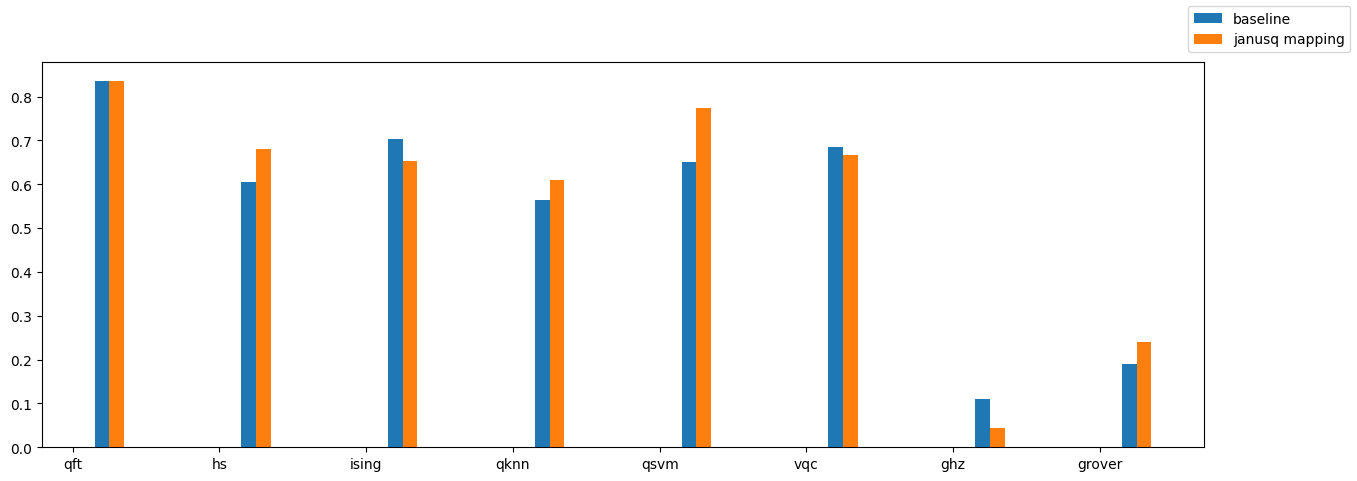

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))  
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq mapping')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()

## Scheduling

We can also use Janus-CT to guide the scheduling.

In [7]:
scheduler = Scheduler(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

before scheduling:  0.8113270770990877 after scheduling:  0.5776407196266011
before scheduling:  0.7024512709407464 after scheduling:  0.4136036810360638
before scheduling:  0.658128319679772 after scheduling:  0.5133597001714554
before scheduling:  0.6263252620157277 after scheduling:  0.42821265119446483
before scheduling:  0.7802371280646782 after scheduling:  0.7750753007042062
before scheduling:  0.6863337084734895 after scheduling:  0.7437670110186058
before scheduling:  0.06449233961620963 after scheduling:  0.14631399092270087
before scheduling:  0.24162381701969524 after scheduling:  0.7564946475636314


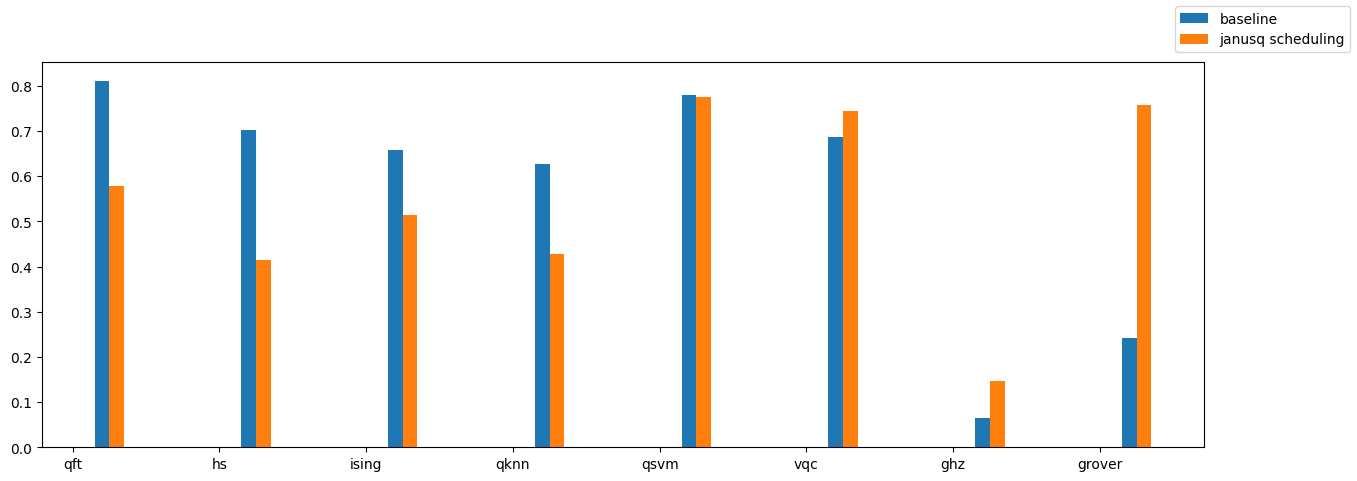

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq scheduling')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()